In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# Carregar dataset
df = pd.read_csv("data/dataset.csv")

# Eliminar id
df = df.drop(columns=["id"])

# Separar target
X = df.drop(columns=["target_variable"])
y = df["target_variable"]

# Definir variables categòriques (les que són binàries o categories)
# categorical_features = [
#     "competitor_Z",
#     "competitor_X",
#     "competitor_Y",
#     "cust_in_iberia"
# ]

# Train/test split estratificat
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear i entrenar model CatBoost
model = CatBoostClassifier(
    iterations=700,          # nombre d’iteracions (arbres)
    depth=8,                 # profunditat màxima dels arbres
    subsample=1.0,
    learning_rate=0.1,      # taxa d’aprenentatge
    l2_leaf_reg=1,
    loss_function="Logloss", # funció de pèrdua
    eval_metric="F1",        # mètrica d’avaluació
    random_seed=42,
    verbose=100              # mostra progress cada 100 iteracions
)

model.fit(X_train, y_train,
          #cat_features=categorical_features
          )

# Prediccions
y_val_proba = model.predict_proba(X_test)[:, 1]

# Threshold tuning per maximitzar F1
thresholds = np.linspace(0.1, 0.9, 81)
best_f1, best_t = -1, None
for t in thresholds:
    y_val_pred = (y_val_proba >= t)
    f1 = f1_score(y_test, y_val_pred)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold:", best_t)
print("Test F1 at best threshold:", best_f1)

# Altres mètriques amb el llindar òptim
y_test_pred = (y_val_proba >= best_t)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


0:	learn: 0.6372834	total: 51.1ms	remaining: 35.7s
100:	learn: 0.7291060	total: 394ms	remaining: 2.33s
200:	learn: 0.7823574	total: 742ms	remaining: 1.84s
300:	learn: 0.8147485	total: 1.1s	remaining: 1.46s
400:	learn: 0.8381228	total: 1.44s	remaining: 1.07s
500:	learn: 0.8549596	total: 1.79s	remaining: 713ms
600:	learn: 0.8667357	total: 2.12s	remaining: 350ms
699:	learn: 0.8765058	total: 2.44s	remaining: 0us
Best threshold: 0.47
Test F1 at best threshold: 0.8182078442599484
Accuracy: 0.8231197771587744
Precision: 0.7921286031042128
Recall: 0.8460627590290113
Confusion Matrix:
 [[3052  750]
 [ 520 2858]]


In [3]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

cat_param_grid = {
    'iterations': [500, 700], # Equivalent to n_estimators
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8], # Equivalent to max_depth
    'l2_leaf_reg': [1, 3, 5], # Regularization parameter
    'subsample': [0.7, 0.9, 1.0],
}

xgb = CatBoostClassifier(
    random_state=42,
    eval_metric="Logloss",
    scale_pos_weight=1 # Explicitly set to 1 (or just remove it, 1 is default)
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=cat_param_grid,
    n_iter=25,
    cv=3,
    scoring='f1',  # Still optimizing for F1!
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

# 4. Get the best model
print(f"Best parameters found: {random_search.best_params_}")
best_cat_model = random_search.best_estimator_

# 5. Evaluate the best model
y_pred = best_cat_model.predict(X_test_scaled)

print("--- Best Model Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
0:	learn: 0.6779090	total: 62.7ms	remaining: 31.3s
0:	learn: 0.6804166	total: 52.8ms	remaining: 26.3s
0:	learn: 0.6785347	total: 71.7ms	remaining: 35.8s
1:	learn: 0.6701698	total: 56.2ms	remaining: 14s
1:	learn: 0.6641758	total: 70.6ms	remaining: 17.6s
2:	learn: 0.6620370	total: 59.6ms	remaining: 9.88s
2:	learn: 0.6526620	total: 77.1ms	remaining: 12.8s
3:	learn: 0.6449180	total: 86ms	remaining: 10.7s
3:	learn: 0.6553308	total: 78ms	remaining: 9.67s
0:	learn: 0.6780218	total: 60.3ms	remaining: 30.1s
4:	learn: 0.6500517	total: 82ms	remaining: 8.12s
4:	learn: 0.6382906	total: 105ms	remaining: 10.4s
5:	learn: 0.6452963	total: 91.2ms	remaining: 7.51s
1:	learn: 0.6650737	total: 74ms	remaining: 18.4s
0:	learn: 0.6810202	total: 57.7ms	remaining: 28.8s
6:	learn: 0.6418133	total: 95.5ms	remaining: 6.73s
2:	learn: 0.6548868	total: 79.4ms	remaining: 13.1s
1:	learn: 0.6672038	total: 116ms	remaining: 28.9s
5:	learn: 0.6322265	total: 115ms	

/home/backo/Documents/datathon-2025/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


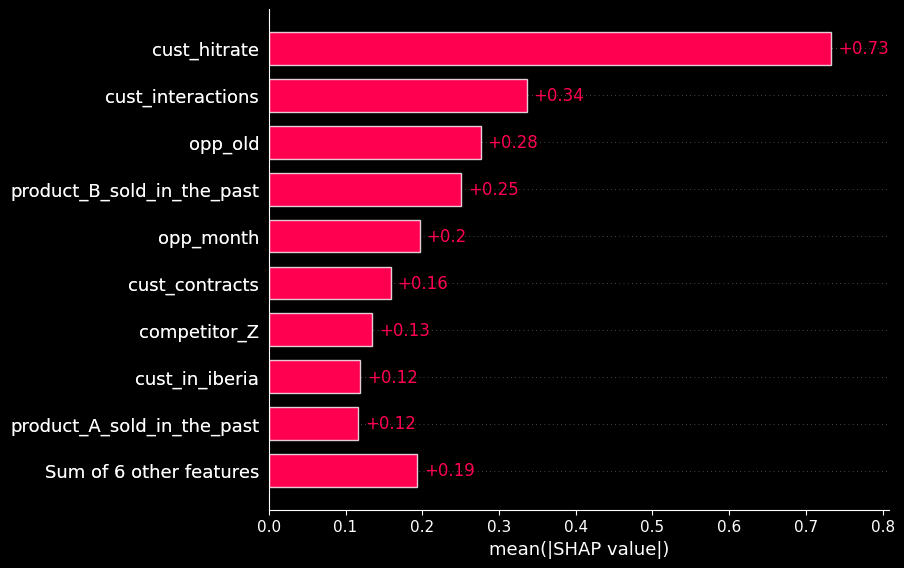

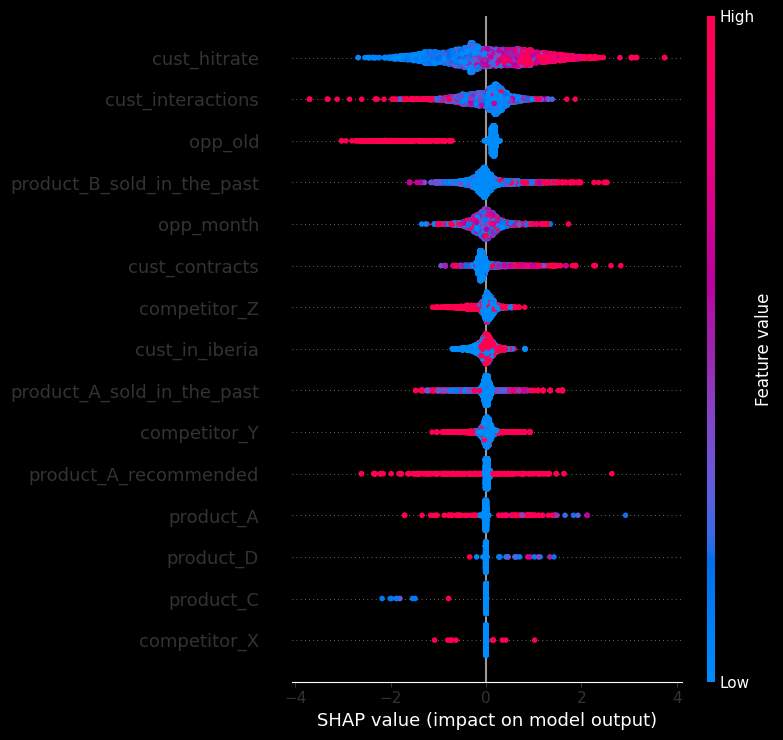

In [4]:
import shap

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
# Assuming 'best_cat_model' is your fitted CatBoost model
cat_explainer = shap.TreeExplainer(best_cat_model)
cat_shap_values = cat_explainer(X_test_scaled_df)

# Generate Plots:
shap.plots.bar(cat_shap_values)
shap.summary_plot(cat_shap_values, X_test_scaled)

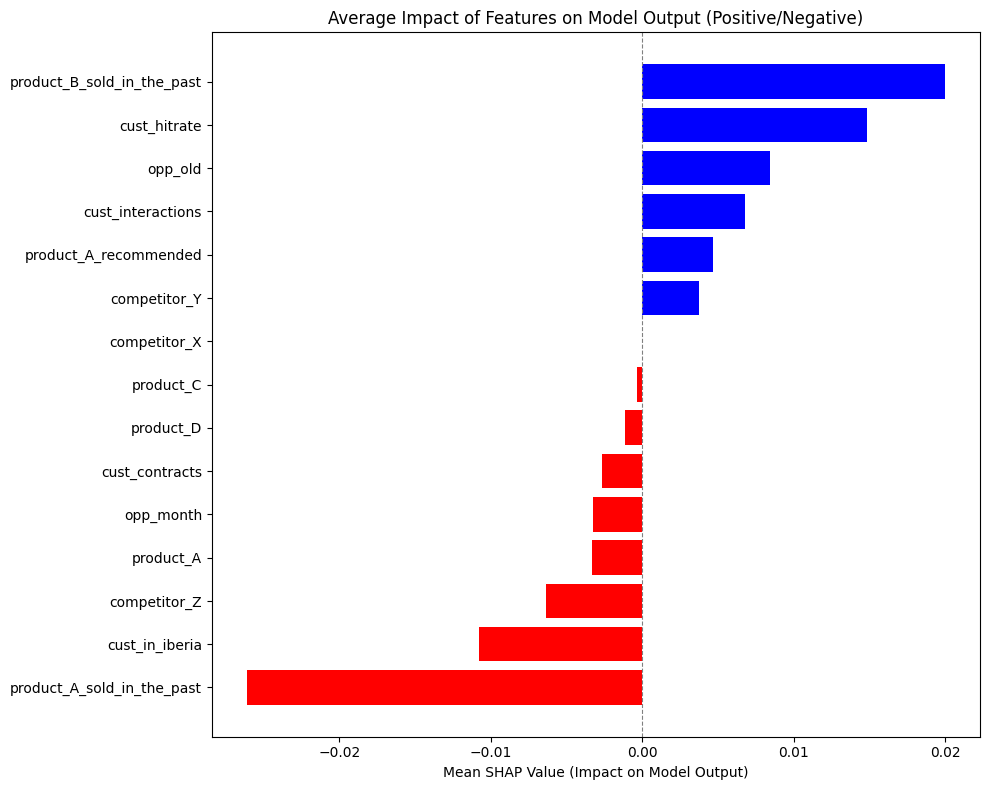

In [37]:
import shap
import matplotlib.pyplot as plt
import numpy as np # For calculating the mean

# Assuming shap_values and X.columns are already defined and shap_values.feature_names is set

# Calculate the mean SHAP value for each feature
# This will preserve the sign (positive or negative)
mean_shap_values = cat_shap_values.values.mean(axis=0)

# Create a DataFrame for easier plotting and sorting
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_shap_value': mean_shap_values
})

# Sort the features by their mean SHAP value for a cleaner plot
shap_df = shap_df.sort_values(by='mean_shap_value', ascending=True)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.barh(shap_df['feature'], shap_df['mean_shap_value'],
         color=['red' if x < 0 else 'blue' for x in shap_df['mean_shap_value']]) # Color based on sign
plt.xlabel("Mean SHAP Value (Impact on Model Output)")
plt.title("Average Impact of Features on Model Output (Positive/Negative)")
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8) # Add a vertical line at 0 for separation
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Model-inbuilt feature importance

                       feature  importance
6                 cust_hitrate   23.690536
7            cust_interactions   19.808609
1   product_B_sold_in_the_past   14.148402
9                    opp_month   12.384414
0   product_A_sold_in_the_past    5.702677
11                competitor_Z    5.162773
8               cust_contracts    4.620209
14              cust_in_iberia    4.147623
13                competitor_Y    3.984997
10                     opp_old    3.280733
2        product_A_recommended    2.113178
3                    product_A    0.683823
5                    product_D    0.112078
12                competitor_X    0.101339
4                    product_C    0.058610


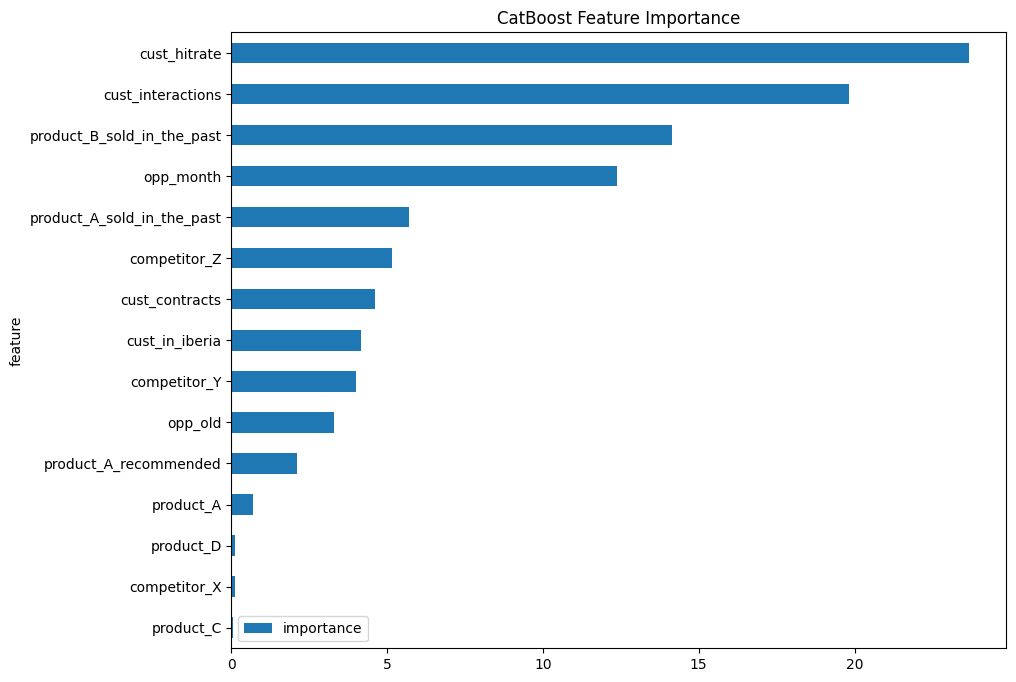

In [38]:
# Get the feature importances
importances = best_cat_model.feature_importances_

# Get your feature names (assuming 'X' is your original unscaled DataFrame)
feature_names = X.columns

# Create a simple bar plot
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(feat_imp_df.sort_values(by='importance', ascending=False))

# You can plot this with matplotlib/seaborn
feat_imp_df.sort_values(by='importance').plot(kind='barh', x='feature', y='importance', figsize=(10, 8))
plt.title("CatBoost Feature Importance")
plt.show()

## Waterfall


--- Explaining Prediction for Case Index 6 ---
Generating SHAP Waterfall plot...


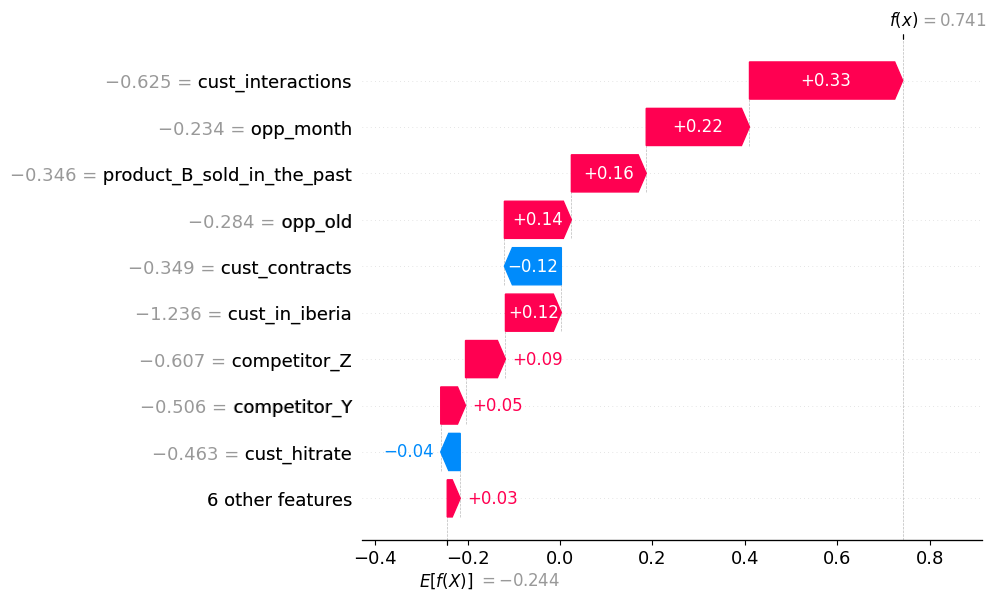


LIME and SHAP plots generated. Check the new window/figures for the visualizations.


In [40]:
instance_index = 6
data_for_lime = X_test_scaled[instance_index]
original_values = X_test.iloc[instance_index]

# Output the predicted class
predicted_proba = best_cat_model.predict_proba(data_for_lime.reshape(1, -1))[0]
predicted_class = np.argmax(predicted_proba)

print(f"\n--- Explaining Prediction for Case Index {instance_index} ---")

# The Waterfall plot takes the specific explanation object for the instance
# Note: shap_values is a list of Explanation objects; index 4 is the one we want.
print("Generating SHAP Waterfall plot...")
shap.plots.waterfall(cat_shap_values[instance_index])

plt.show()

print("\nLIME and SHAP plots generated. Check the new window/figures for the visualizations.")
